# Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW
### MUSA 650 Final

**Authors: Benjamin She, Eli Ericson**

In [2]:
import os, cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

from glob import glob
from matplotlib import colors
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output

In [3]:
# define params

BASEDIR = 'data'

# due to filestructure, each city's images are in a separate folder
CITIES = ['koeln']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']
CLASSES = {
    0:'forest',
    1:'water',
    2:'agricultural',
    3:'urban_fabric',
    4:'grassland',
    5:'railway',
    6:'highway',
    7:'air_ship',
    8:'road',
    9:'building',
    10: 'other'}

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 4
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
# define segmentation mask color map and function to plot it
# very lightly adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

lcov_cmap = colors.ListedColormap(
    [
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
        "#f5f6f7",  # light gray for other
    ]
)
lcov_norm = colors.Normalize(vmin=0, vmax=10)

def seg2rgb(seg_map):
    """ Converts segmentation map to plottable RGB image. """
    return lcov_cmap(lcov_norm(np.squeeze(seg_map)))[:, :, :3]

## Image preprocessing

In [5]:
# get filepaths of each image and mask and print length

filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 479 - Masks: 479


In [6]:
def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512,512))
    x = x.astype(np.uint8)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512,512), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    recodes = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
    x_recoded = np.zeros_like(x)
    for k, v in recodes.items():
        x_recoded[x == k] = v
    return x_recoded

def show_img_mask(arrImg, arrMsk, i):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask']
    display_list = [arrImg[i,:,:,:],seg2rgb(arrMsk[i,:,:,:])]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
    plt.show()

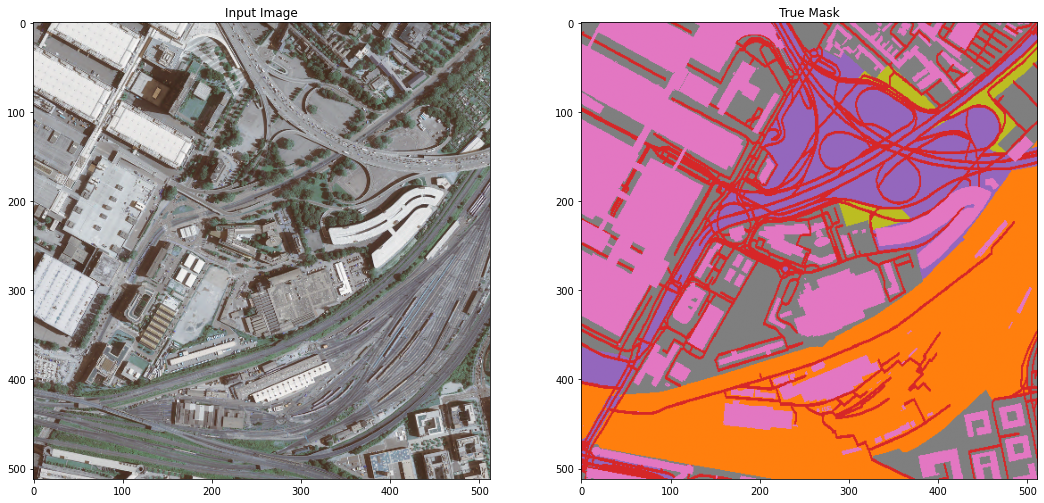

In [22]:
arrImg, arrMsk = [], []

for imgFile in filesImg:
    arrImg.append(read_image(imgFile))
for mskFile in filesMsk:
    arrMsk.append(read_mask(mskFile))

arrImg = np.asarray(arrImg)
arrMsk = np.asarray(arrMsk)

show_img_mask(arrImg, arrMsk, 266)

In [23]:
# split all images and masks into four as orthoimagery scale is too big

arrImgS, arrMskS = [], []

M = arrImg[0].shape[0]//2
N = arrImg[0].shape[1]//2

for im in arrImg:
    arrImgS.extend([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

for mk in arrMsk:
    arrMskS.extend([mk[x:x+M,y:y+N] for x in range(0,mk.shape[0],M) for y in range(0,mk.shape[1],N)])

arrImgS = np.asarray(arrImgS)
arrMskS = np.asarray(arrMskS)

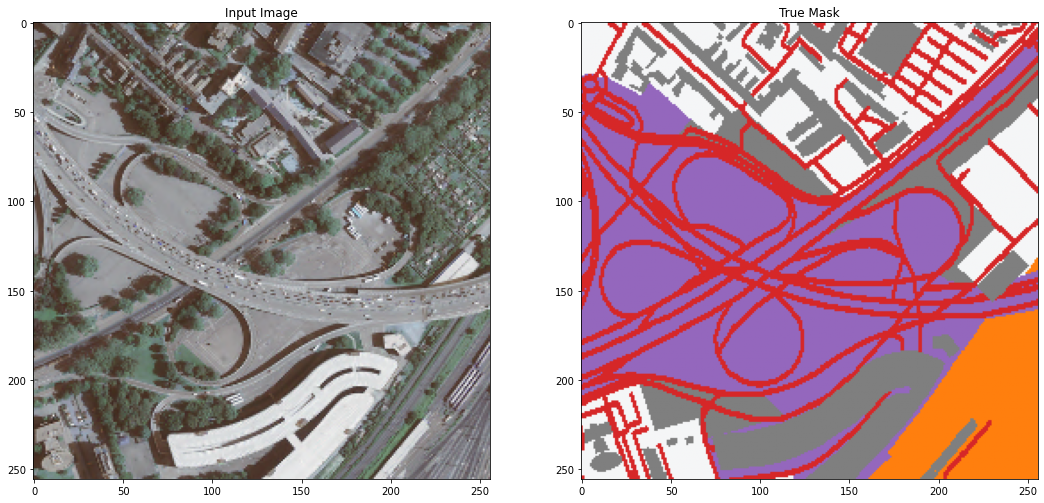

In [42]:
def recode2cmap(arrMskSRed):
    """Recodes reduced-class dataset to match color map for plotting."""
    
    map_dict = {0: 10, 1: 5, 2: 6, 3: 7, 4: 8, 5: 3}
    masks_recolored = np.zeros_like(arrMskSRed)
    
    for k, v in map_dict.items():
        masks_recolored[arrMskSRed == k] = v
        
    return masks_recolored

# Remap image masks according to CMAP color pallete

classSel = {0: 0, 1: 0, 2: 0, 3: 0, 4: 5, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5}

arrMskSRed = np.zeros_like(arrMskS)

for k, v in classSel.items():
    arrMskSRed[arrMskS == k] = v

show_img_mask(arrImgS, recode2cmap(arrMskSRed), 1064)

In [25]:
def getMasksClasses(masklist, numClasses):
    '''returns a dict with the indices of masks sorted by the number of classes
    present in them'''
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

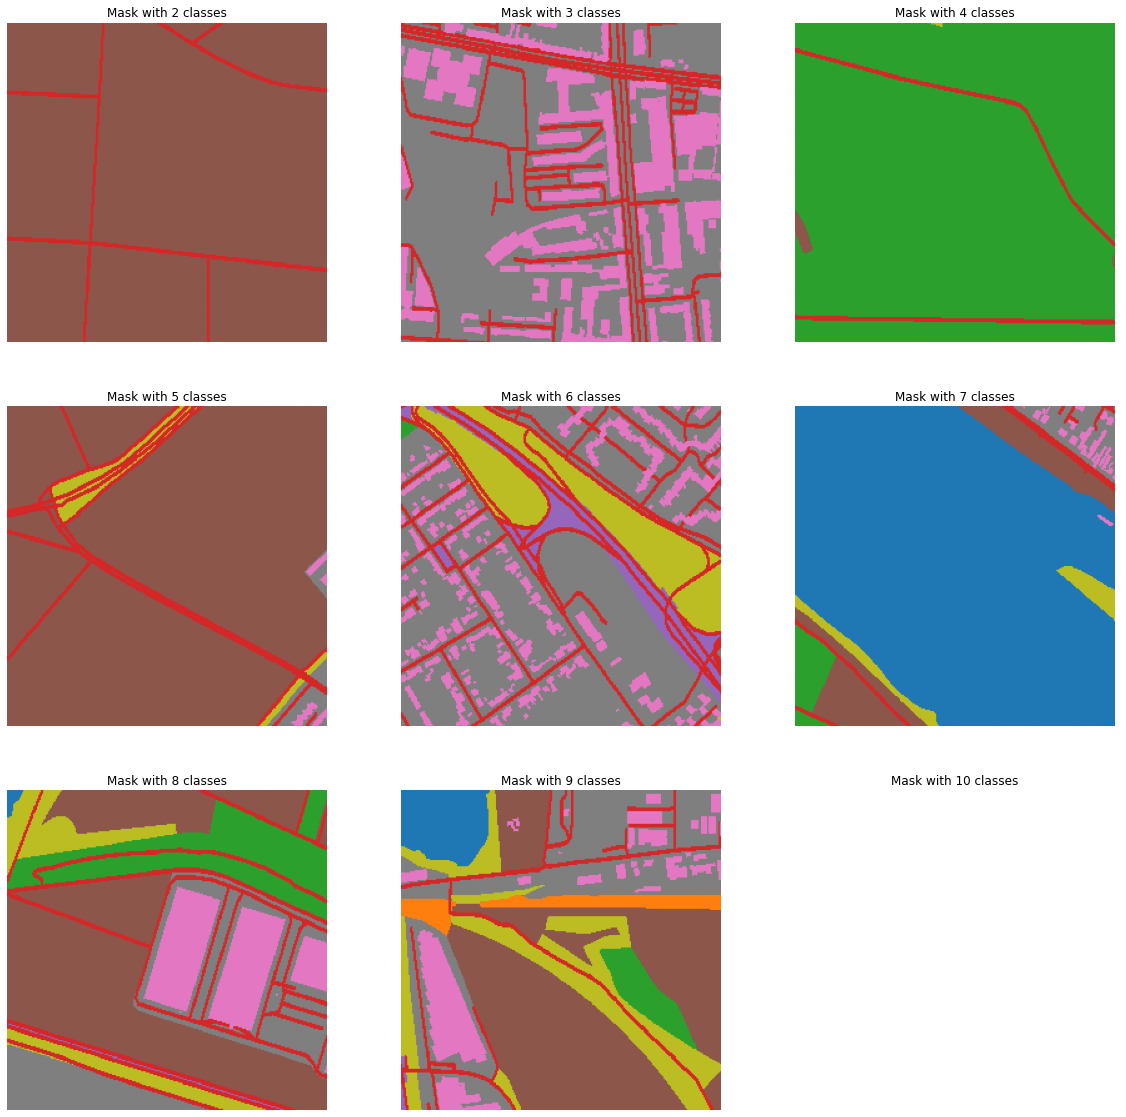

In [26]:
# get classes by masks
mskByClass = getMasksClasses(arrMskS, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(20,20), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i+1} classes')
  classMsk = arrMskS[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(arrMskS[mskByClass[i+1][np.random.randint(classMsk.shape[0])]]), vmin=0, vmax=NUM_CLASSES)

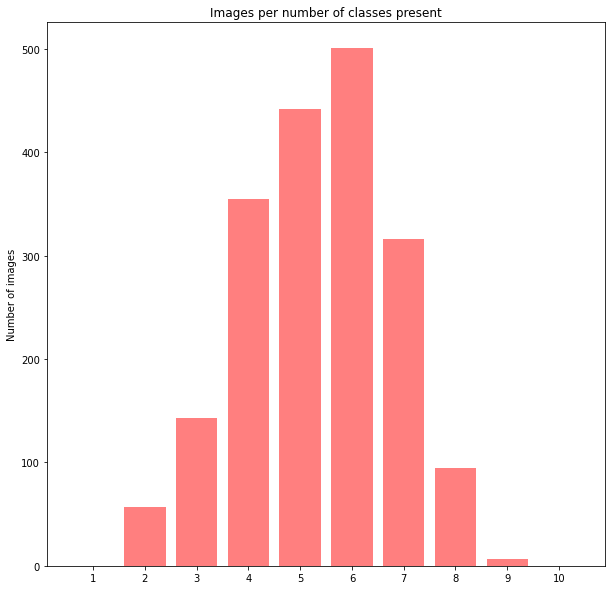

In [27]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(10,10))
plt.bar(np.arange(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

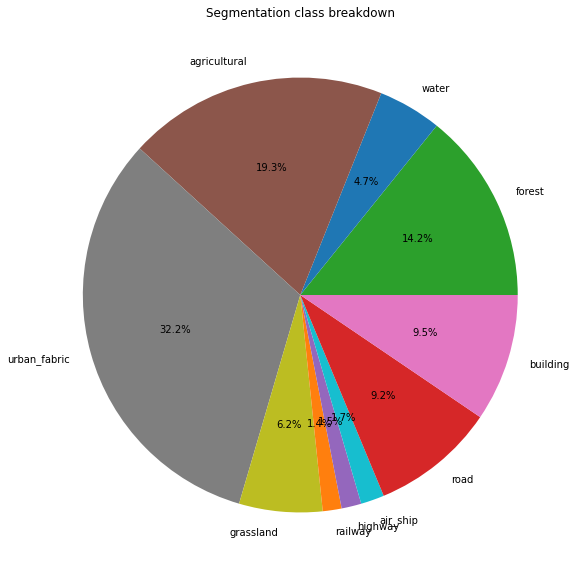

In [28]:
(classNum, counts) = np.unique(arrMsk, return_counts=True)
classNum = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(10,10))
plt.pie(counts, labels=classNum, colors=lcov_cmap.colors, autopct='%1.1f%%')
plt.title("Segmentation class breakdown")
plt.show()

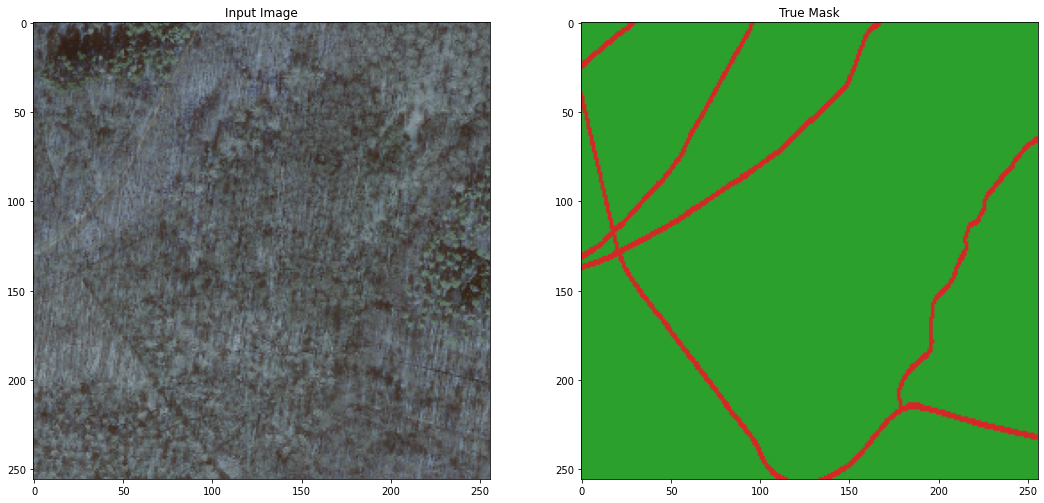

In [29]:
# get index of masks that contain railways, highways, airports/shipyards, and roads, and filter dataset to only those

ROWidxs = []
for i in range(len(arrMskS)):
    if True in np.in1d(arrMskS[i].flatten(),[6,7,8,9]):
        ROWidxs.append(i)

arrImgS = np.take(arrImgS,ROWidxs,axis=0)
arrMskS = np.take(arrMskS,ROWidxs,axis=0)

[len(arrImgS), len(ROWidxs)]

show_img_mask(arrImgS, arrMskS, 4)

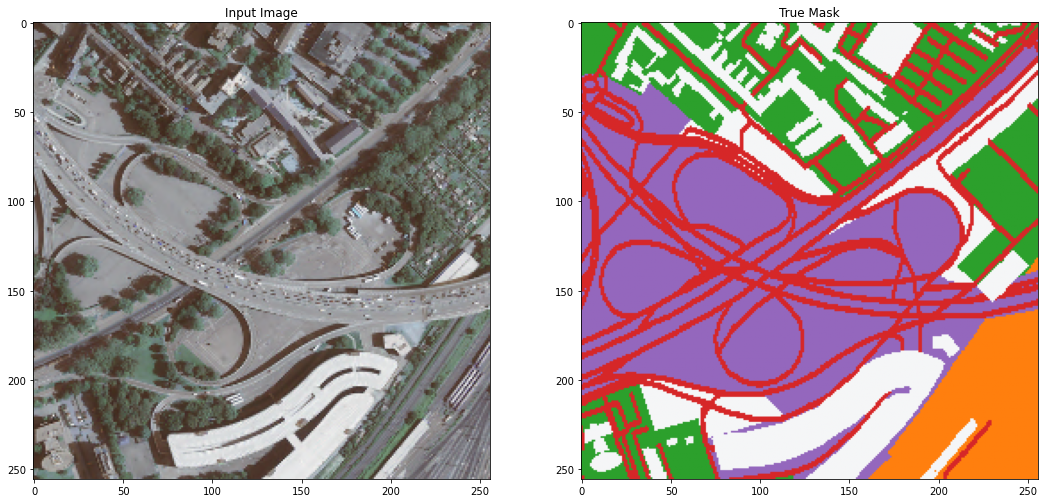

In [35]:
# reduce semantic classes to highways, roadways, railways, airports/ports, and all other

classSel = {0: 0, 1: 0, 2: 0, 3: 5, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 0}

arrMskSRed = np.zeros_like(arrMskS)

for k, v in classSel.items():
    arrMskSRed[arrMskS == k] = v

show_img_mask(arrImgS, recode2cmap(arrMskSRed), 1064)

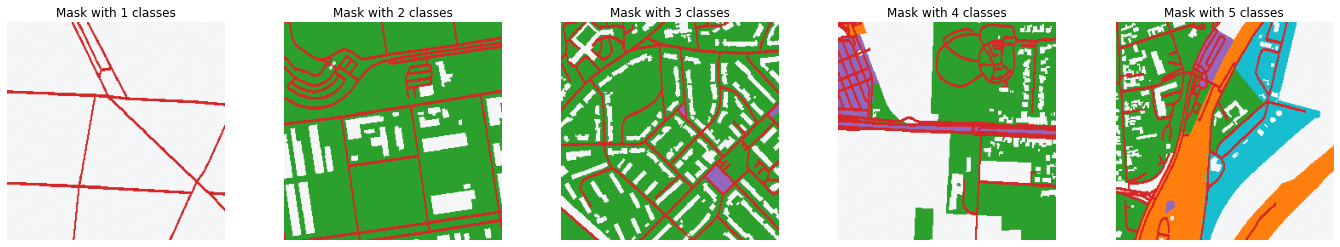

In [31]:
NUM_CLASSES_RED = len(np.unique(arrMskSRed))

# get classes by masks
mskByClass = getMasksClasses(arrMskSRed, NUM_CLASSES_RED)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(24,4), nrows=1, ncols=NUM_CLASSES_RED-1, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES_RED):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i} classes')
  classMsk = arrMskSRed[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(recode2cmap(arrMskSRed[mskByClass[i+1][np.random.randint(classMsk.shape[0])]])), 
              vmin=0, vmax=NUM_CLASSES)

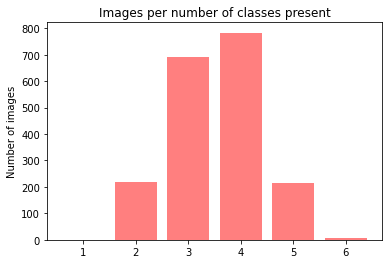

In [32]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES_RED+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES_RED+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES_RED+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

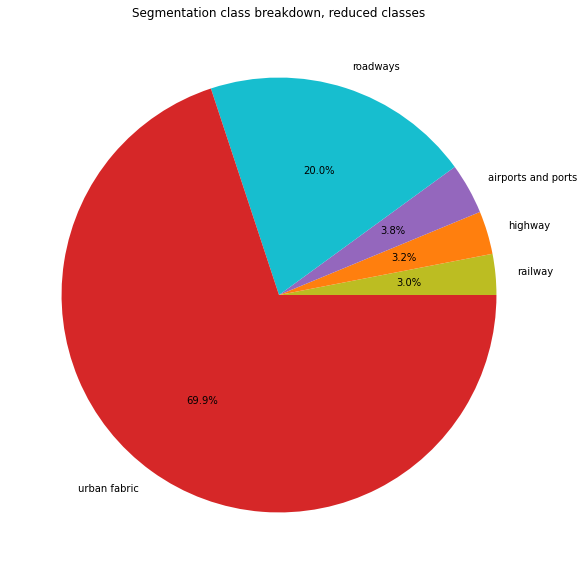

In [33]:
recode = {0: "Other", 1: "railway", 2: "highway", 3: "airports and ports", 4: "roadways", 5: "urban fabric", 6: "building"}

(classNum, counts) = np.unique(arrMskSRed[arrMskSRed > 0], return_counts=True)
classNum = np.vectorize(recode.get)(classNum)

plt.figure(figsize=(10,10))
plt.pie(counts, labels=classNum, colors=lcov_cmap.colors[4:9], autopct='%1.1f%%')
plt.title("Segmentation class breakdown, reduced classes")
plt.show()

## CNN modeling (U-Net)

In [55]:
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [56]:
# geonrw = tf.data.Dataset.from_tensor_slices((arrImgS, arrMskS))
# geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
# geonrw = geonrw.batch(BATCH_SIZE)
# geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

In [57]:
# dataset = {"train":geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.8)),
#             "test":geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.8))}

In [58]:
# Split to train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    arrImgS,
    arrMskS,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

In [59]:
def downsample_block(x, n_filters, dropout=0.1):
   f = double_conv_block(x, n_filters, dropout)
   p = MaxPooling2D(2)(f)
   return f, p

def double_conv_block(x, n_filters, dropout):
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Dropout(dropout)(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Dropout(dropout)(x)
   return x

def upsample_block(x, conv_features, n_filters, dropout=0.1):
   x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(x)
   x = concatenate([x, conv_features])
   x = double_conv_block(x, n_filters, dropout)
   return x

In [60]:
def build_unet():
    # inputs
    inputs = Input(shape=(INPUT_SHAPE))
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0.1)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.1)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.2)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.2)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.3)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.2)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.2)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.1)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0.1)
    # outputs
    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [61]:
model = build_unet()

model.summary()

Error: Canceled future for execute_request message before replies were done

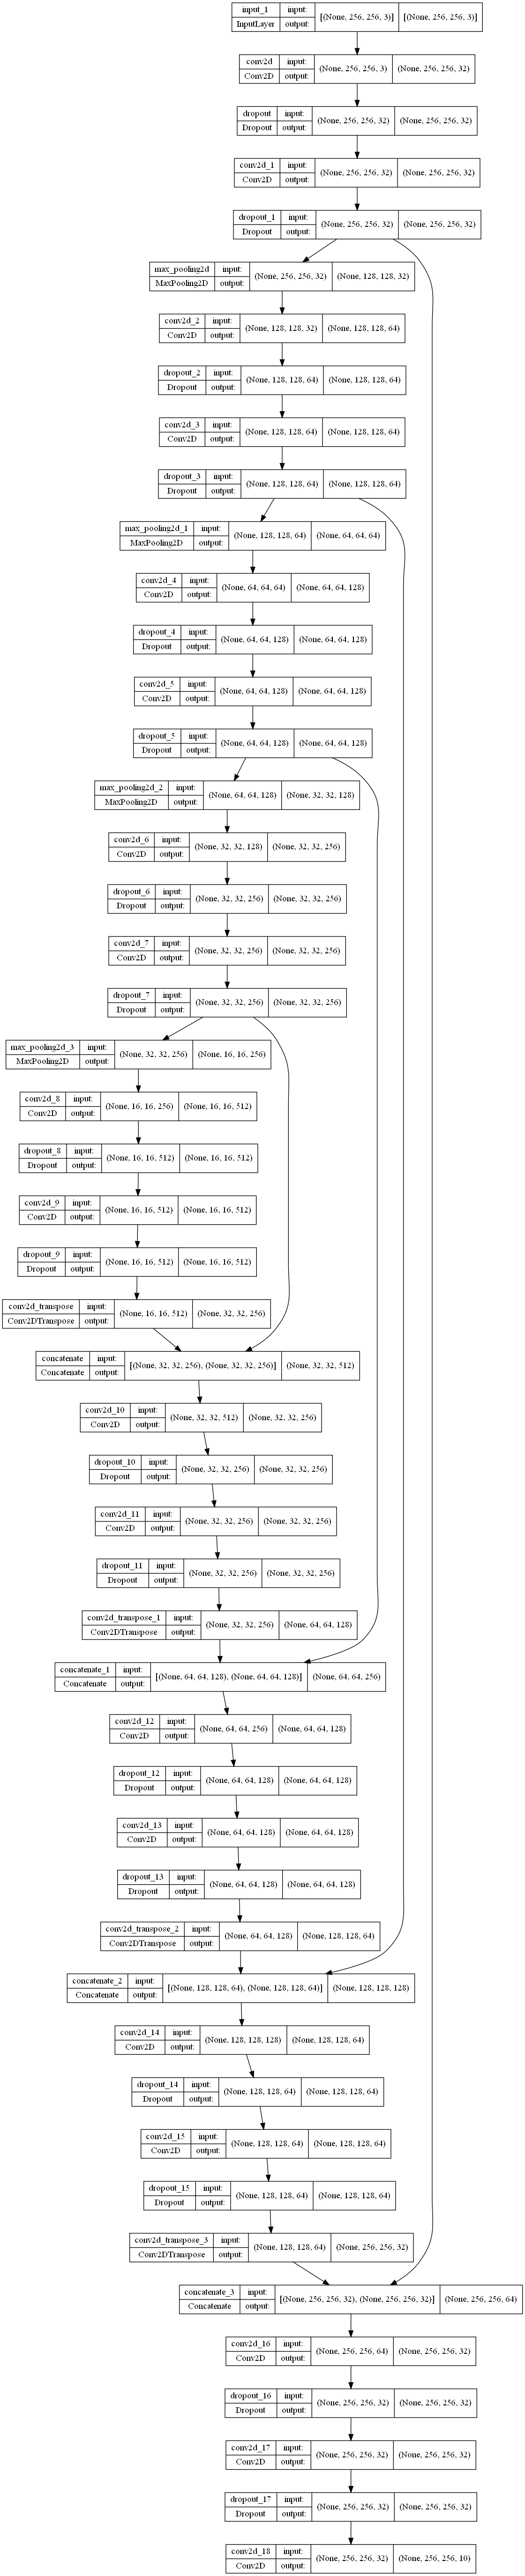

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Define custom loss and metrics

from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=SparseCategoricalCrossentropy(from_logits=True,
                                     reduction="auto",
                                     name="categorical_crossentropy"),
                    metrics=[iou_coef, "accuracy"])

In [ ]:
# Functions for mask prediction and visualization

def display_sample(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

sample_image, sample_mask = (X_tr[1], y_tr[1])

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

In [ ]:
NUM_EPOCHS = 20
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss',patience=3, verbose=1),
    # to save checkpoints
    ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x =  X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

Epoch 1/20
383/383 [==============================] - ETA: 0s - loss: -21.2342 - iou_coef: -1.4684 - accuracy: 0.1412
Epoch 1: val_loss improved from inf to -23.01280, saving model to best_model_unet.h5
383/383 [==============================] - 38s 90ms/step - loss: -21.2342 - iou_coef: -1.4684 - accuracy: 0.1412 - val_loss: -23.0128 - val_iou_coef: -1.7067 - val_accuracy: 0.1383 - lr: 1.0000e-04
Epoch 2/20
383/383 [==============================] - ETA: 0s - loss: -22.7740 - iou_coef: -1.4397 - accuracy: 0.1429
Epoch 2: val_loss did not improve from -23.01280
383/383 [==============================] - 34s 90ms/step - loss: -22.7740 - iou_coef: -1.4397 - accuracy: 0.1429 - val_loss: -23.0128 - val_iou_coef: -1.7067 - val_accuracy: 0.1383 - lr: 1.0000e-04
Epoch 3/20
383/383 [==============================] - ETA: 0s - loss: -22.8462 - iou_coef: -1.4381 - accuracy: 0.1429
Epoch 3: val_loss did not improve from -23.01280
383/383 [==============================] - 35s 90ms/step - loss: -2

## Running preductions



In [ ]:
prediction = model(np.expand_dims(X_tr[42], 0)).numpy()
segmentation = np.argmax(prediction, axis=-1)

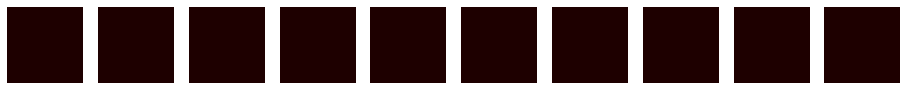

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, 4))
[axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), cmap='pink')

In [ ]:
for i in range(5):
    min_ = np.min(prediction[..., i])
    max_ = np.max(prediction[..., i])
    mean = np.mean(prediction[..., i])
    std = np.std(prediction[..., i])
    print(f"Channel {i} min is {min_}, max is {max_}, mean is {mean}, std is {std}")

Channel 0 min is 1.0, max is 1.0, mean is 1.0, std is 0.0
Channel 1 min is 1.0, max is 1.0, mean is 1.0, std is 0.0
Channel 2 min is 1.0, max is 1.0, mean is 1.0, std is 0.0
Channel 3 min is 1.0, max is 1.0, mean is 1.0, std is 0.0
Channel 4 min is 1.0, max is 1.0, mean is 1.0, std is 0.0


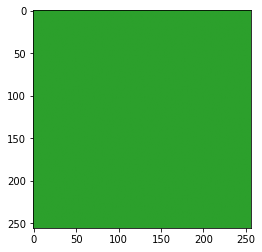

In [ ]:
plt.imshow(seg2rgb(np.squeeze(segmentation)))

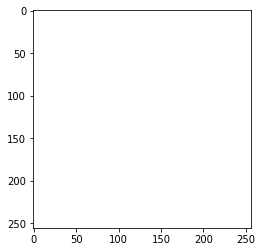

In [ ]:
plt.imshow(np.squeeze(prediction[..., 3]), vmin=0, vmax=1, cmap='pink')

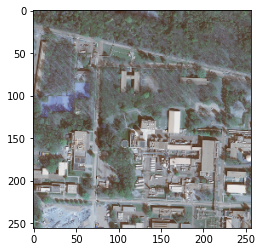

In [ ]:
plt.imshow(X_tr[42])

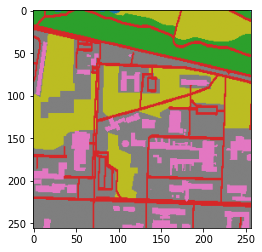

In [ ]:
plt.imshow(seg2rgb(y_tr[42]))

In [ ]:
from numba import cuda
cuda.get_current_device().reset()